# **Import library**

In [ ]:
import cv2
import random
import os
from glob import glob
from google.colab.patches import cv2_imshow
import pandas as pd


In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


# **Load dataset**

In [ ]:
!cp /content/drive/Shareddrives/SuperAI2-Final-Hackathon/DataSet.zip /content/

In [ ]:
!unzip -qq DataSet.zip

In [ ]:
!cp DataSet/Image.zip /content/
!unzip -qq Image.zip

In [ ]:
!unzip -qq IM_Train.zip

In [ ]:
!unzip -qq IM_Test.zip

# **Visualize dataset**

8


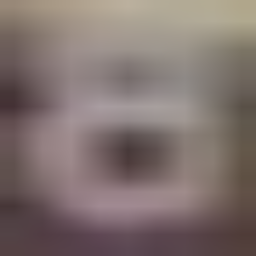

In [ ]:
idx = random.randint(0, 10)
_fname = glob(f"/content/train/{idx}/*.png")
print(idx)
image = cv2.imread(_fname[0])
im_resize = cv2.resize(image, (256, 256), cv2.INTER_AREA)
cv2_imshow(im_resize)

In [ ]:
image.shape

(18, 9, 3)

# **Data Preprocessing**

# **Train Data Manipulation**

In [ ]:
import numpy as np
import cv2
import matplotlib
from matplotlib import pyplot as plt
import os
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
import pickle
from sklearn.model_selection import train_test_split

In [ ]:
def create_data_dict(character_dict : dict):

  for c in range(0, 10) :
    _keys = str(c)
    character_dict[_keys] = []
    _fname = glob(f"train/{c}/*.png")
    for image in _fname :
      im = cv2.imread(image)
      character_dict[_keys].append(im)

  return character_dict

In [ ]:
def preprocessing_data(character_dict : dict, x : list, y : list):
  for character_name, images in character_dict.items(): #files are the lists of each player image
    for image in images:
        scaled_image = cv2.resize(image, (32, 32))
        scaled_image = scaled_image.reshape(32*32*3,1)
        x.append(scaled_image)
        y.append(int(character_name))
  x = np.array(x).reshape(len(x),3072).astype(float)

  return x, y

In [ ]:
character_dict = {}
x = []
y = []

character_dict = create_data_dict(character_dict)
x, y = preprocessing_data(character_dict, x, y)

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, y, stratify=y, test_size=0.2)

In [ ]:
print(len(x_train), len(y_train))

58605 58605


# **Train data using deep learning**

In [ ]:
!pip install timm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 509 kB 3.2 MB/s 


In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torch.optim as optim
import timm
from timm.models.efficientnet import default_cfgs
from sklearn.model_selection import train_test_split 
import torch.nn.functional as F

device     = torch.device("cuda" if torch.cuda.is_available() else "cpu")
import albumentations as  A

In [ ]:
def generate_trainset(_filename : list, labels : list):
  for idx in range(0,10) :
    f_name = glob(f"/content/train/{idx}/*.png")
    for f in f_name :
      _filename.append(f)
      labels.append(idx)

  return _filename, labels

In [ ]:
_f = []
_labels = []

x_train_ls, y_train_ls = generate_trainset(_f, _labels)

In [ ]:
# x_train_ls
train_df = pd.DataFrame(x_train_ls)

In [ ]:
train_df = train_df = train_df.rename(columns = {0 : "fname"})
train_df["Label"] = _labels
train_df.head(3)

,fname,Label
0,/content/train/0/8391.1.png,0
1,/content/train/0/16226.2.png,0
2,/content/train/0/23025.2.png,0


In [ ]:
#split train val set 
df_train, df_val = train_test_split(train_df, test_size = 0.1, random_state = 42)
df_train = df_train.reset_index(drop = True)
df_train.shape, df_val.shape

((65931, 2), (7326, 2))

# **Model Parameters**

In [ ]:
import torchvision.transforms as transforms
from torchvision.utils import save_image
from torch.utils.data import Dataset
from PIL import Image
import time
import numpy as np

In [ ]:
from torchvision.transforms.autoaugment import RandAugment
from torchvision.transforms.functional import posterize

torchvision_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((32, 32)),
    # transforms.RandAugment(),
    transforms.ToTensor(),
])

torchvision_transform_validate = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((32, 32)),
    #transforms.RandAugment(),
    transforms.ToTensor(),
])



In [ ]:
img_size = 32

class ImageDataset(torch.utils.data.Dataset):
    def __init__(self, df ,transforms = None, img_size = img_size):
        self.X = list(df['fname'])
        self.y =list(df['Label'])
        self.img_size = img_size
        self.transforms = transforms

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):

      image = cv2.imread(self.X[idx])
      image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
      image = cv2.resize(image, (self.img_size, self.img_size), 3)
     

      if  self.transforms is not None :
        im = self.transforms(image) 

      return {'image': torch.FloatTensor(im), 'label': self.y[idx]}


In [ ]:
train_dataset = ImageDataset(df_train,
                             transforms =torchvision_transform,
                             img_size = img_size )

val_dataset = ImageDataset(df_val,
                           transforms =torchvision_transform_validate,
                           img_size = img_size)

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
val_loader = DataLoader(val_dataset, batch_size = batch_size, shuffle = False)

In [ ]:
class ClassifierModel(torch.nn.Module):
    def __init__(self,n_dim1 = 256,num_class=5,dropout_rate=0.2):
        super(ClassifierModel, self).__init__() 
        # defining our deep learning architecture
        self.resnet_model = timm.create_model(
                    'resnet34',
                    pretrained=True)
        self.droupout1 = torch.nn.Dropout(p=dropout_rate)
        self.droupout2 = torch.nn.Dropout(p=dropout_rate)

        self.fc1 = torch.nn.Linear(1000, n_dim1)
        self.fc2 = torch.nn.Linear(n_dim1, num_class)

    def forward(self, x,get_feat = False):
        # x = torch.unsqueeze(x, 1)
        # x = self.conv1(x)
        # x = torch.swapaxes(x, 1, -1)
        x = x / 255
        x = self.resnet_model(x)
        if not get_feat:
            x = self.droupout1(x)
            x = self._mlp(x)
            # x = torch.nn.functional.softmax(x,dim=1)
        return x
    
    def _mlp(self,x):
        x = self.fc1(x)
        x = torch.nn.functional.leaky_relu(x)
        x = self.droupout2(x)
        x = self.fc2(x)
        return x

model = ClassifierModel()
x = torch.randn((1,3,112,112))
model(x)#.argmax(axis=1)

tensor([[ 0.0821,  0.0951, -0.0579, -0.0687,  0.0193]],
       grad_fn=<AddmmBackward0>)

In [ ]:
import os
import shutil
import sys
import time
from tqdm import tqdm

In [ ]:
def compute_accuracy(logit,label):
    pred_label = logit.argmax(axis=1)
    return (pred_label==label).sum()/logit.shape[0]

In [ ]:
def stream(message) :
    try:
        sys.stdout.write("\r{%s}" % message)
    except:
        #Remove non-ASCII characters from message
        message = ''.join(i for i in message if ord(i)<128)
        sys.stdout.write("\r{%s}" % message)

In [ ]:
def compute_avg_w(l): # (data,num_batch)
    sum_w_loss = 0
    sum_w = 0
    for i in l:
        sum_w_loss+=i[0]*i[1]
        sum_w+=i[1]
    return sum_w_loss/sum_w

In [ ]:
def save_checkpoint(state, is_best, filename='checkpoint.pth.tar'):
    torch.save(state, filename)
    if is_best:
        shutil.copyfile(filename, 'model_best.pth.tar')

In [ ]:
output_directory = '/content/drive/Shareddrives/SuperAI2-Final-Hackathon'
patience = 5

In [ ]:
from sklearn.metrics import f1_score
def train_model(model, train_loader, val_loader, epochs):

    
    best_epoch = 0
    best_val_loss = np.inf
    #class_weights = torch.FloatTensor(weights).to(device)
    criterion = torch.nn.CrossEntropyLoss().to(device)
    optimizer = torch.optim.Adam(model.parameters(),  lr=0.001)
    

    # Tell wandb to watch what the model gets up to: gradients, weights, and more!
    #wandb.watch(model, criterion, log="all", log_freq=10)

    for epoch in range(epochs):
        print("Epoch :{}/{}".format(epoch+1, epochs))
        
        model.train()
        pred = []

        cnt = tqdm(enumerate(train_loader))

        for i, batch in cnt:
        
            start_time = time.time()
            optimizer.zero_grad()
            img = batch['image'].to(device)
            label = batch['label'].to(device)

            #img.swapaxes(1, 3)

            logit = model(img)
            loss = criterion(logit, label)
            loss.backward()
            optimizer.step()
            num_step = i + len(train_loader) * epoch
            step_loss = loss.item()
            step_accuracy = compute_accuracy(logit,label).item()
            pred+=[(step_accuracy,label.shape[0])]

            msg = f"| Epoch: {epoch+1}/{epochs} ({i+1}/{len(train_loader)}) | Loss: {step_loss:#.4} | Accuracy: {step_accuracy:#.4} | {1./(time.time() - start_time):#.3} steps/s | Step: {num_step//1000}k |"
            cnt.set_description(msg)
            # stream(msg)

        epoch_train_accuracy =compute_avg_w(pred)
        msg = f"\n\n| Train Accuracy: {epoch_train_accuracy:#.4} |"
        print(msg, flush = True)

        model.eval()
        losses = []
        pred = []

        y_true = []
        y_pred = []
        for i, batch in enumerate(val_loader) :
            img = batch['image'].to(device)
            label = batch['label'].to(device)

            #img = img.swapaxes(1, 3)
            
            with torch.no_grad():
                logit = model(img)
                loss = criterion(logit,label)
                y_true += label.tolist()
                y_pred += logit.argmax(axis=1).tolist()
            losses+=[(loss.item(),label.shape[0])]
            pred+=[(compute_accuracy(logit,label),label.shape[0])]
            F1 = f1_score(y_true, y_pred, average='macro')

        epoch_val_loss = compute_avg_w(losses)
        epoch_val_accuracy =compute_avg_w(pred).item()

        msg = f"| Val Loss: {epoch_val_loss:#.4} | Val Accuracy: {epoch_val_accuracy:#.4} | Macro_score :{F1:#.4} |\n"
        print(msg)

        if best_val_loss>=epoch_val_loss:
            best_val_loss = epoch_val_loss
            best_epoch = epoch
            # Save Best Checkpoint
            save_checkpoint({
                    'epoch': epoch + 1,
                    'state_dict': model.state_dict(),
                    'optimizer' : optimizer.state_dict(),
                }, is_best=False, filename=os.path.join(output_directory, 'best_checkpoint.pth.tar'.format(epoch)))
            
        if epoch-best_epoch>patience :
            break            

In [ ]:

model = ClassifierModel(num_class = 10).to(device)
train_model(model, train_loader, val_loader, 20) 

Epoch :1/20


| Epoch: 1/20 (1031/1031) | Loss: 0.5961 | Accuracy: 0.8182 | 25.0 steps/s | Step: 1k |: : 1031it [01:10, 14.64it/s]



| Train Accuracy: 0.7875 |


| Val Loss: 0.4557 | Val Accuracy: 0.8661 | Macro_score :0.8605 |

Epoch :2/20


| Epoch: 2/20 (1031/1031) | Loss: 1.163 | Accuracy: 0.7273 | 30.7 steps/s | Step: 2k |: : 1031it [01:00, 16.90it/s]



| Train Accuracy: 0.8699 |


| Val Loss: 0.4472 | Val Accuracy: 0.8728 | Macro_score :0.8684 |

Epoch :3/20


| Epoch: 3/20 (1031/1031) | Loss: 0.1301 | Accuracy: 1.000 | 26.2 steps/s | Step: 3k |: : 1031it [01:01, 16.85it/s]



| Train Accuracy: 0.8890 |


| Val Loss: 0.3997 | Val Accuracy: 0.8833 | Macro_score :0.8809 |

Epoch :4/20


| Epoch: 4/20 (1031/1031) | Loss: 0.1649 | Accuracy: 1.000 | 34.2 steps/s | Step: 4k |: : 1031it [01:01, 16.83it/s]



| Train Accuracy: 0.9074 |


| Val Loss: 0.3510 | Val Accuracy: 0.8972 | Macro_score :0.8956 |

Epoch :5/20


| Epoch: 5/20 (1031/1031) | Loss: 0.3717 | Accuracy: 0.8182 | 33.6 steps/s | Step: 5k |: : 1031it [01:00, 17.10it/s]



| Train Accuracy: 0.9151 |


| Val Loss: 0.4165 | Val Accuracy: 0.8766 | Macro_score :0.8759 |

Epoch :6/20


| Epoch: 6/20 (1031/1031) | Loss: 0.3961 | Accuracy: 0.8182 | 34.1 steps/s | Step: 6k |: : 1031it [00:59, 17.29it/s]



| Train Accuracy: 0.9150 |


| Val Loss: 0.3419 | Val Accuracy: 0.9024 | Macro_score :0.9007 |

Epoch :7/20


| Epoch: 7/20 (1031/1031) | Loss: 1.029 | Accuracy: 0.5455 | 34.6 steps/s | Step: 7k |: : 1031it [01:00, 17.07it/s]



| Train Accuracy: 0.9137 |


| Val Loss: 0.3652 | Val Accuracy: 0.8942 | Macro_score :0.8919 |

Epoch :8/20


| Epoch: 8/20 (1031/1031) | Loss: 0.8544 | Accuracy: 0.7273 | 33.6 steps/s | Step: 8k |: : 1031it [00:59, 17.31it/s]



| Train Accuracy: 0.9260 |


| Val Loss: 0.3068 | Val Accuracy: 0.9133 | Macro_score :0.9114 |

Epoch :9/20


| Epoch: 9/20 (1031/1031) | Loss: 0.5084 | Accuracy: 0.8182 | 31.6 steps/s | Step: 9k |: : 1031it [01:00, 17.01it/s]



| Train Accuracy: 0.9292 |


| Val Loss: 0.3159 | Val Accuracy: 0.9161 | Macro_score :0.9139 |

Epoch :10/20


| Epoch: 10/20 (1031/1031) | Loss: 0.2990 | Accuracy: 0.9091 | 33.5 steps/s | Step: 10k |: : 1031it [00:59, 17.29it/s]



| Train Accuracy: 0.9186 |


| Val Loss: 0.3356 | Val Accuracy: 0.9090 | Macro_score :0.9071 |

Epoch :11/20


| Epoch: 11/20 (1031/1031) | Loss: 0.2940 | Accuracy: 0.9091 | 34.1 steps/s | Step: 11k |: : 1031it [00:59, 17.28it/s]



| Train Accuracy: 0.9060 |


| Val Loss: 0.4340 | Val Accuracy: 0.8817 | Macro_score :0.8787 |

Epoch :12/20


| Epoch: 12/20 (1031/1031) | Loss: 0.4445 | Accuracy: 0.8182 | 33.9 steps/s | Step: 12k |: : 1031it [00:59, 17.33it/s]



| Train Accuracy: 0.9431 |


| Val Loss: 0.3091 | Val Accuracy: 0.9159 | Macro_score :0.9137 |

Epoch :13/20


| Epoch: 13/20 (1031/1031) | Loss: 2.505 | Accuracy: 0.6364 | 34.3 steps/s | Step: 13k |: : 1031it [00:59, 17.31it/s]



| Train Accuracy: 0.9539 |


| Val Loss: 0.3472 | Val Accuracy: 0.9083 | Macro_score :0.9048 |

Epoch :14/20


| Epoch: 14/20 (1031/1031) | Loss: 0.08628 | Accuracy: 0.9091 | 33.7 steps/s | Step: 14k |: : 1031it [00:59, 17.26it/s]



| Train Accuracy: 0.9255 |


| Val Loss: 0.3237 | Val Accuracy: 0.9095 | Macro_score :0.9076 |



In [ ]:

model_chpt = torch.load("/content/drive/Shareddrives/SuperAI2-Final-Hackathon/best_checkpoint.pth.tar")
model.load_state_dict(model_chpt['state_dict'])

<All keys matched successfully>

In [ ]:
test_torchvision_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((32, 32)),
    #transforms.RandAugment(),
    transforms.ToTensor(),
])

In [ ]:
img_size = 32
f_path = "/content/IM_Test/IM_Test/"
class ImageDataset(torch.utils.data.Dataset):
    def __init__(self, df ,file_path, transforms = None, img_size = img_size):
        self.X = list(df['fname'])
        self.img_size = img_size
        self.transforms = transforms
        self.file_path = file_path

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):

      image = cv2.imread(self.file_path + self.X[idx])
      image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
      image = cv2.resize(image, (self.img_size, self.img_size), 3)
     

      if  self.transforms is not None :
        im = self.transforms(image) 

      return {'image': torch.FloatTensor(im) }


In [ ]:
from natsort import natsorted

In [ ]:
t_name = os.listdir("/content/IM_Test/IM_Test")
asc_t_name = natsorted(t_name)
test_fname = pd.DataFrame(asc_t_name)
test_fname = test_fname.rename(columns = {0 : "fname"})

In [ ]:
f_path = "/content/IM_Test/IM_Test/"
test_dataset = ImageDataset(test_fname,
                            f_path,
                           transforms = test_torchvision_transform,
                           img_size = img_size)

batch_size = 1
test_loader = DataLoader(test_dataset, batch_size = batch_size, shuffle =False)

# Predictions